In [41]:
from enum import Enum, auto

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


class NoiseType(Enum):
    DIAGONAL = auto()
    ISOTROPIC = auto()
    ISOTROPIC_ACROSS_CLUSTERS = auto()
    FIXED = auto()


class MixtureDensityNetwork(nn.Module):
    """
    Mixture density network.

    [ Bishop, 1994 ]

    Parameters
    ----------
    dim_in: int; dimensionality of the covariates
    dim_out: int; dimensionality of the response variable
    n_components: int; number of components in the mixture model
    """
    def __init__(self, dim_in, dim_out, n_components, hidden_dim, noise_type=NoiseType.DIAGONAL, fixed_noise_level=None):
        super().__init__()
        assert (fixed_noise_level is not None) == (noise_type is NoiseType.FIXED)
        num_sigma_channels = {
            NoiseType.DIAGONAL: dim_out * n_components,
            NoiseType.ISOTROPIC: n_components,
            NoiseType.ISOTROPIC_ACROSS_CLUSTERS: 1,
            NoiseType.FIXED: 0,
        }[noise_type]
        self.dim_in, self.dim_out, self.n_components = dim_in, dim_out, n_components
        self.noise_type, self.fixed_noise_level = noise_type, fixed_noise_level
        self.pi_network = nn.Sequential(
            nn.Linear(dim_in, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_components),
        )
        self.normal_network = nn.Sequential(
            nn.Linear(dim_in, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim_out * n_components + num_sigma_channels)
        )

    def forward(self, x, eps=1e-6):
        #
        # Returns
        # -------
        # log_pi: (bsz, n_components)
        # mu: (bsz, n_components, dim_out)
        # sigma: (bsz, n_components, dim_out)
        #
        log_pi = torch.log_softmax(self.pi_network(x), dim=-1)
        normal_params = self.normal_network(x)
        mu = normal_params[..., :self.dim_out * self.n_components]
        sigma = normal_params[..., self.dim_out * self.n_components:]
        if self.noise_type is NoiseType.DIAGONAL:
            sigma = torch.exp(sigma + eps)
        if self.noise_type is NoiseType.ISOTROPIC:
            sigma = torch.exp(sigma + eps).repeat(1, self.dim_out)
        if self.noise_type is NoiseType.ISOTROPIC_ACROSS_CLUSTERS:
            sigma = torch.exp(sigma + eps).repeat(1, self.n_components * self.dim_out)
        if self.noise_type is NoiseType.FIXED:
            sigma = torch.full_like(mu, fill_value=self.fixed_noise_level)
        mu = mu.reshape(-1, self.n_components, self.dim_out)
        sigma = sigma.reshape(-1, self.n_components, self.dim_out)
        return log_pi, mu, sigma

    def loss(self, x, y):
        log_pi, mu, sigma = self.forward(x)
        z_score = (y.unsqueeze(1) - mu) / sigma
        normal_loglik = (
            -0.5 * torch.einsum("bij,bij->bi", z_score, z_score)
            -torch.sum(torch.log(sigma), dim=-1)
        )
        loglik = torch.logsumexp(log_pi + normal_loglik, dim=-1)
        return -loglik

    def sample(self, x):
        log_pi, mu, sigma = self.forward(x)
        cum_pi = torch.cumsum(torch.exp(log_pi), dim=-1)
        rvs = torch.rand(len(x), 1).to(x)
        rand_pi = torch.searchsorted(cum_pi, rvs)
        rand_normal = torch.randn_like(mu) * sigma + mu
        samples = torch.take_along_dim(rand_normal, indices=rand_pi.unsqueeze(-1), dim=1).squeeze(dim=1)
        return samples

In [42]:
data = np.load('/Users/pipipu/Desktop/STHSL/Datasets/NYC_crime/trn.pkl',allow_pickle = True)
row, column, time, cat = data.shape
data = data.reshape(-1, time, cat)
data = np.sum(data, axis = 2)
data = data.reshape(time,row * column)
data = torch.from_numpy(data)
data_X = data[:-1,:]
data_y = data[1:,:]


In [84]:
model = MixtureDensityNetwork(row*column,row*column,2,512).double()
# Define the loss function
loss_function = nn.MSELoss()
# Define the optimizer
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()
epoch = 10
for i in range(epoch):
    total_loss = 0
    for j in range(int(time/2)):
        optimizer.zero_grad()
        x = data_X[j,:]
        y = data_y[j,:]
        x = x.reshape(1,-1)
        y = y.reshape(1,-1)
       
        loss = model.loss(x,y).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss
    print(f"Epoch {epoch+1}/{epoch}, Loss: {average_loss:.4f}")
        

Epoch 11/10, Loss: 452566.8899
Epoch 11/10, Loss: 33553.0778
Epoch 11/10, Loss: -4580.2126
Epoch 11/10, Loss: -9652.9138
Epoch 11/10, Loss: -16621.4902
Epoch 11/10, Loss: -16695.0296
Epoch 11/10, Loss: -23851.8769
Epoch 11/10, Loss: -29822.5250
Epoch 11/10, Loss: -25355.4228
Epoch 11/10, Loss: -28393.0086


In [73]:
torch.argmax(model.sample(data_X).reshape(-1,1).int())

tensor(91669)

In [72]:
data_y.reshape(-1,1)[91815]

tensor([20.], dtype=torch.float64)

In [74]:
model.sample(data_X).reshape(-1,1).int()[91669]

tensor([312932], dtype=torch.int32)

In [108]:
log_pi, mu, sigma = model.forward(data_X)
pi = torch.exp (log_pi)
mu.shape

torch.Size([607, 2, 256])

In [109]:
import torch

# Define the original matrix


# Add a third dimension
expanded_matrix = torch.unsqueeze(pi, dim=2)
print(expanded_matrix.shape)
# Repeat the matrix along the third dimension
final_matrix = expanded_matrix.repeat(1,1,256)

# Print the final matrix
torch.min(torch.sum(final_matrix * mu,axis = 1))


torch.Size([607, 2, 1])


tensor(-0.4052, dtype=torch.float64, grad_fn=<MinBackward1>)

torch.Size([607, 2, 256])

torch.Size([512, 1])
torch.Size([512, 1])


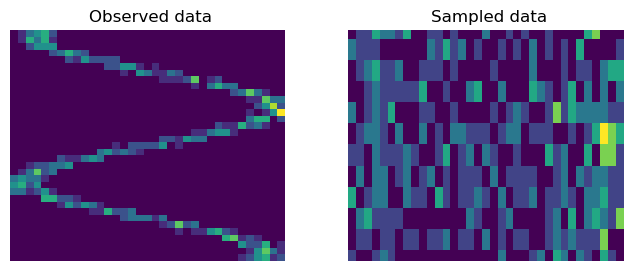

In [70]:


from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.optim as optim




def gen_data(n=512):
    y = np.linspace(-1, 1, n)
    x = 7 * np.sin(5 * y) + 0.5 * y + 0.5 * np.random.randn(*y.shape)
    return x[:,np.newaxis], y[:,np.newaxis]

def plot_data(x, y):
    plt.hist2d(x, y, bins=35)
    plt.xlim(-8, 8)
    plt.ylim(-1, 1)
    plt.axis('off')


if __name__ == "__main__":

    

    x, y = gen_data()
    x = torch.Tensor(x)
    y = torch.Tensor(y)
    print(x.shape)
    print(y.shape)
    model = MixtureDensityNetwork(1, 1, n_components=3, hidden_dim=50, noise_type=NoiseType.DIAGONAL)
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 30)

    for i in range(1):
        optimizer.zero_grad()
        loss = model.loss(x, y).mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
       
    with torch.no_grad():
        y_hat = model.sample(x)

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plot_data(x[:, 0].numpy(), y[:, 0].numpy())
    plt.title("Observed data")
    plt.subplot(1, 2, 2)
    plot_data(x[:, 0].numpy(), y_hat[:, 0].numpy())
    plt.title("Sampled data")
    plt.show()